In [2]:
import os
import h5py
import numpy as np
import math

from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from scipy.signal import fftconvolve
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D

In [3]:
filePath = r"C:\Users\Lab User\Desktop\experiment data\07292025\Scan_4.hdf5"
dataPath = f'/RawData/Scan_4'

with h5py.File(filePath,'r') as f: 
    data = f[dataPath][()] # (slices, rows, width)
data = np.transpose(data,[1,2,0]) # (rows, width, slices)
dataCropped = data[150:1100,50:970,:]
cR, cW, cZ = np.shape(dataCropped)

In [4]:
highPct, medPct = 99, 95

# Apply median filter and threshold
threshHigh = np.percentile(dataCropped, highPct)
filteredData = median_filter(dataCropped, size=(3, 3, 3))
dataCropped[dataCropped > threshHigh] = filteredData[dataCropped > threshHigh]

# Update threshold and replace values above it with the median
threshHigh = np.percentile(dataCropped, highPct)
dataCropped[dataCropped > threshHigh] = np.mean(np.percentile(dataCropped, medPct))


In [5]:
meanPerCol = np.mean(dataCropped,axis=(1,2))
meanCenterRow = meanPerCol[math.floor(cR/2)]
scales = meanCenterRow/meanPerCol

dataColNorm = dataCropped*scales[:, np.newaxis, np.newaxis]
dataNorm = np.clip(exposure.rescale_intensity(dataColNorm, in_range='image', out_range=(0,1)), 0, 1)

blurred = gaussian_filter(dataNorm, sigma=3)
strength = 0.2
dataSharp = np.clip(dataNorm + strength * blurred, 0, 1)

Text(0.5, 1.0, 'Sharp')

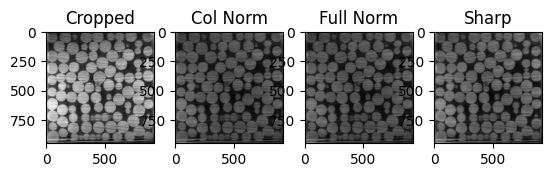

In [6]:
plt.subplot(1,4,1)
plt.imshow(dataCropped[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Cropped')

plt.subplot(1,4,2)
plt.imshow(dataColNorm[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Col Norm')

plt.subplot(1,4,3)
plt.imshow(dataNorm[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Full Norm')

plt.subplot(1,4,4)
plt.imshow(dataSharp[:,:,math.floor(cZ/2)], cmap='gray')
plt.title('Sharp')

In [7]:
from skimage.transform import probabilistic_hough_line
import cv2
from PIL import Image

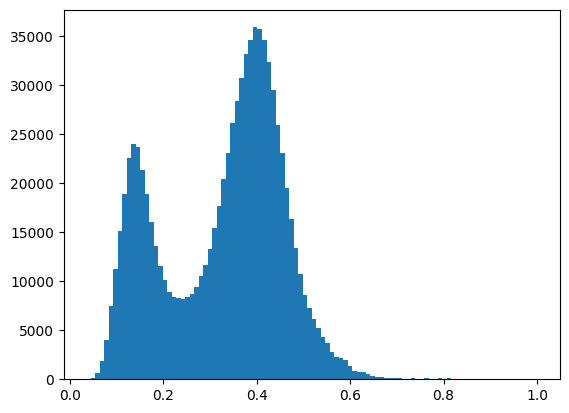

In [8]:
# Line finding using the Probabilistic Hough Transform
mid = dataSharp[:,:,math.floor(cZ/2)]
scaleFactor = 0.5
dataRescale = zoom(mid, scaleFactor, order=1)
plt.hist(mid.flatten(), bins=100)
plt.show()


In [9]:
midn = (mid*255).astype(np.uint8)
edges = cv2.Canny(midn, 0.1*255, 0.4*255)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

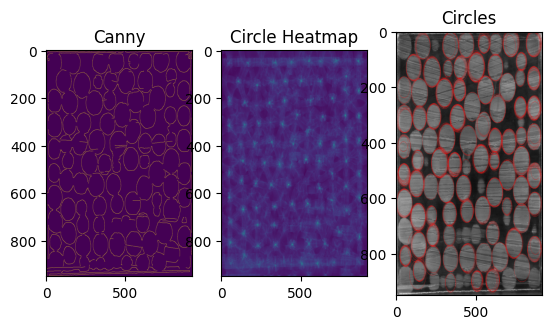

In [ ]:
# Load picture and detect edges
image = img_as_ubyte(mid)
edges = canny(image, sigma=2.75)

plt.subplot(1,3,1)
plt.imshow(edges, aspect=75)
plt.title('Canny')

hough_radii = np.arange(30, 60, 2)
hough_res = hough_circle(edges, hough_radii)

heatmap = hough_res.max(axis=0)
plt.subplot(1,3,2)
plt.imshow(heatmap, aspect=75.5)
plt.title('Circle Heatmap')

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,threshold=.25)

# Draw them
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)

plt.subplot(1,3,3)
plt.imshow(image, aspect=1.75)
plt.title('Circles')
plt.show()

#ax.imshow(image, cmap=plt.cm.gray)
#plt.show()

NameError: name 'cm' is not defined

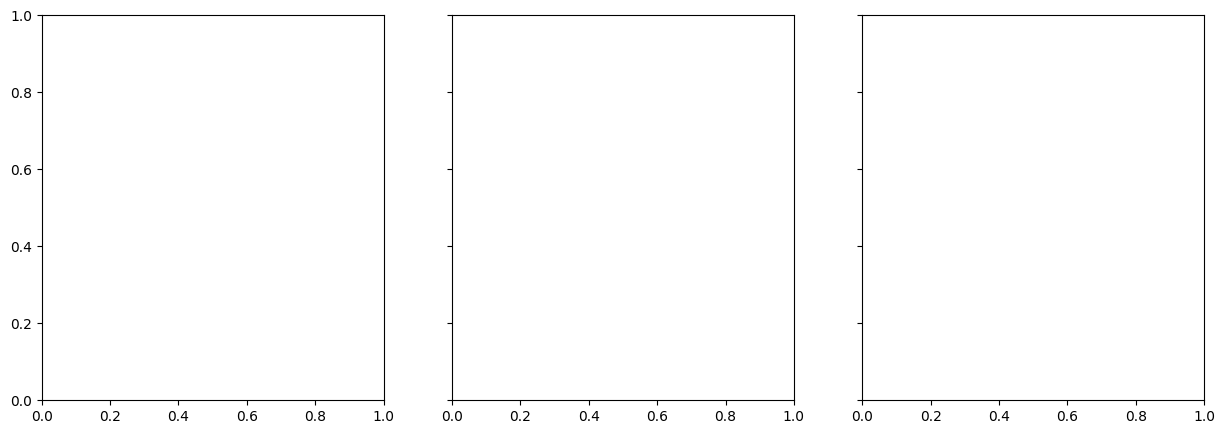

In [12]:
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# Downsample
scaleFactor = 0.5
dataRescale = zoom(dataSharp, scaleFactor, order=1)

In [ ]:

# Particle detection

D, w = 100*scaleFactor, 2.5*scaleFactor
Cutoff, MinSep = 5, 75*scaleFactor
ss = int(2*(D/2 + 4*w/2)-1)
os = (ss-1)//2
xx, yy, zz = np.meshgrid(np.arange(-os,os+1), np.arange(-os,os+1), np.arange(-os,os+1), indexing='ij')
r = np.sqrt(xx**2 + yy**2 + zz**2)
ipi = ipf3D(r, D, w)
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
# Sub-voxel refinement
cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
ci = ipf3D(r_full, D, w)
di = ci - dataRescale
chi2 = np.sum(di**2)

nr, delchi2, mindelchi2, maxnr = 0, 1e99, 1, 5
while abs(delchi2)>mindelchi2 and nr<maxnr:
    dpx, dpy, dpz = cidp23D(cxyz, over, di, Np, D, w)
    px += dpx; py += dpy; pz += dpz
    cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
    r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
    ci = ipf3D(r_full, D, w)
    di = ci - dataRescale
    delchi2 = chi2 - np.sum(di**2)
    chi2 -= delchi2
    nr += 1

In [ ]:

# Visualization

# Max projection of residual
plt.figure()
plt.imshow(np.max(di**2, axis=2), cmap='gray', origin='lower')
plt.colorbar()
plt.title(f'Residual Chi^2 (max projection), Chi2={chi2:.2f}')
plt.show()

In [ ]:
# 3D scatter of particle centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px, py, pz, c='r', s=50)
ax.set_xlim(0, dataRescale.shape[1])
ax.set_ylim(0, dataRescale.shape[0])
ax.set_zlim(0, dataRescale.shape[2])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Detected particle centers')
plt.show()
